# **Import Libraries**

In [ ]:
pip install emoji --upgrade

     |████████████████████████████████| 51kB 1.5MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=b0aaac0b5e89aae97b6dc3a5ace773fd18f853cb799a835be56e001c8d912112
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import numpy as np
from time import time

#Data Preprocessing and Feature Engineering
import unicodedata
from textblob import TextBlob
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
import emoji
from nltk.tokenize import TweetTokenizer
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib


#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier  
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import f1_score, make_scorer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_tweets = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/NLP/NLP HW1/train.csv',encoding = "ISO-8859-1")

In [ ]:
test_tweets = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/NLP/NLP HW1/test.csv',encoding = "ISO-8859-1")

In [ ]:
test_tweets

,id,text
0,7322,@AmericanAir In car gng to DFW. Pulled over 1h...
1,7323,"@AmericanAir after all, the plane didnÂÃÂªt ..."
2,7324,@SouthwestAir can't believe how many paying cu...
3,7325,@USAirways I can legitimately say that I would...
4,7326,@AmericanAir still no response from AA. great ...
...,...,...
7315,14637,@JetBlue Traveling with two kids tomorrow (age...
7316,14638,@JetBlue Tx for the info. Just don't understan...
7317,14639,@AmericanAir I understand. But why is this the...
7318,14640,@USAirways really!??


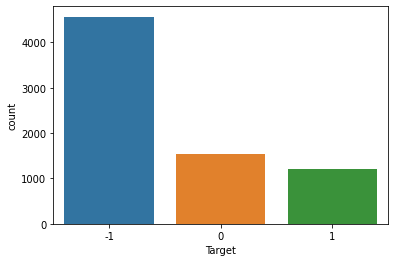

In [ ]:
sns.countplot(x=train_tweets['Target'], data=train_tweets)

In [ ]:
X = train_tweets.drop(['Id', 'Target'], axis=1)
y = pd.DataFrame(train_tweets['Target'])

In [ ]:
X

,text
0,@USAirways ! THE WORST in customer service. @...
1,@united call wait times are over 20 minutes an...
2,@JetBlue what's up with the random delay on fl...
3,@AmericanAir Good morning! Wondering why my p...
4,@united UA 746. Pacific Rim and Date Night cut...
...,...
7315,@AmericanAir followback
7316,@united thanks for the help. Wish the phone re...
7317,@usairways the. Worst. Ever. #dca #customerser...
7318,@nrhodes85: look! Another apology. DO NOT FLY ...


In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [ ]:
#X['clean_tweet'] = X['text'].apply(lambda x: remove_pattern(x,"@[\w]*"))
#X.head(10)

In [ ]:
 def count_regex(pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))

# **Creating Text Features**

In [ ]:
# Based on https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/

def feature_counts(X):
        #all the alphanumeric character
        count_words = X.apply(lambda x: count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [ ]:
X_feat_counts = feature_counts(X.text)
X_feat_counts

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,18,2,2,2,3,0,0
1,14,1,0,0,0,0,0
2,19,1,0,0,2,0,0
3,17,1,0,1,2,0,0
4,18,1,0,1,0,0,0
...,...,...,...,...,...,...,...
7315,2,1,0,0,0,0,0
7316,13,1,0,0,0,0,0
7317,6,1,2,0,0,0,0
7318,8,2,0,3,1,0,0


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Custom Extensible Tokenizer**


In [ ]:
# Shorter version of http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
# Shorter version adapted from https://github.com/dbamman/anlp19/blob/master/1.words/ExploreTokenization.ipynb

# The order here is important (match from first to last)
import re

# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)
regexes=(r"(?:@[\w_]+)",

# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",

# Keep words with apostrophes, hyphens and underscores together
#r"(?:[a-z][a-z’'\-_]+[a-z])",

# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",

# Everything else that's not whitespace
r"(?:\S)"
)

big_regex="|".join(regexes)

my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)

def my_extensible_tokenize(text):
    return my_extensible_tokenizer.findall(text)

In [ ]:
tokens = []
tokens = [' '.join(my_extensible_tokenize(X.loc[i, "text"])) for i in range(len(X))]

In [ ]:
X["token_text"]=tokens

# **Text Cleaning**

In [ ]:
# Based on https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# Based on https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)

    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no",'who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stemming).apply(self.remove_stopwords)
        return clean_X

In [ ]:
ct = CleanText()
clean_text = []
clean_text = ct.fit_transform(X.token_text)

In [ ]:
#empty_clean = clean_text == ''
#print('{} records have no words left after text cleaning'.format(clean_text[empty_clean].count()))
#clean_text.loc[empty_clean] = '[no_text]'

10 records have no words left after text cleaning


In [ ]:
clean_text = pd.DataFrame(clean_text)
clean_text.columns = ['clean_text']
X["clean_text"] = clean_text

In [ ]:
X2 = pd.concat([X, X_feat_counts], axis=1, sort=False,ignore_index=True)
X2.columns = ['text','token_text','clean_text','count_words', 'count_mentions', 'count_hashtags',
       'count_capital_words', 'count_excl_quest_marks', 'count_urls',
       'count_emojis']
X=X2

In [ ]:
feat_counts = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']

# **Train-Test-Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 46)

In [ ]:
f1 = make_scorer(f1_score , average='macro')

# **GridSearch**

In [ ]:
class FeatureExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_search_fn(clf, parameters_clf, X_train, X_test, parameters_vect=None, vect=None):
    
    features = FeatureUnion([('feat_counts', FeatureExtractor(cols=feat_counts))
                                 , ('pipe', Pipeline([('cleantext', FeatureExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1
                            )
    
    pipeline = Pipeline([
        ('features', features)
        , ('classifier', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_vect:
        parameters.update(parameters_vect)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5,scoring='f1_macro')
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

## **Parameters**

In [ ]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_cvec = {
    'features__pipe__vect__max_df': (0.95, 1.0),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}
parameters_tfidf = {
    'features__pipe__vect__max_df': (0.95, 1.0),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_MNB = {
    'classifier__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logit = {
    'classifier__C': (0.25, 0.5, 1.0),
    'classifier__penalty': ('l1', 'l2')
}

parameters_XGB = {
        'classifier__max_depth': [3, 4, 5]
        }

In [ ]:
MNB = MultinomialNB()
logit = LogisticRegression(max_iter=1000)
XGB = XGBClassifier(silent=False)
cvec = CountVectorizer()
tfidf = TfidfVectorizer()


# **Logistic Regression with Count Vectorizer**



In [ ]:
# LogisticRegressionWithCvec
best_logit_cvec = grid_search_fn(logit, parameters_logit, X_train, X_test, parameters_vect=parameters_cvec, vect=cvec)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__C': (0.25, 0.5, 1.0),
 'classifier__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done in 458.051s

Best CV score: 0.720
Best parameters set:
	classifier__C: 0.5
	classifier__penalty: 'l2'
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.777


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.84      0.88      0.86       893
           0       0.63      0.58      0.60       326
           1       0.72      0.66      0.69       245

    accuracy                           0.78      1464
   macro avg       0.73      0.71      0.72      1464
weighted avg       0.77      0.78      0.77      1464



**Best parameters set:**
	
  classifier__C: 0.5
	
  classifier__penalty: 'l2'
	
  features__pipe__vect__max_df: 0.95
	
  features__pipe__vect__min_df: 1
	
  features__pipe__vect__ngram_range: (1, 1)

Test score with best_estimator_: 0.777

## **Predict F1 score**

In [ ]:
y_pred = best_logit_cvec.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.7167004745108786

# **Logistic Regression with Tfidf Transformer**


In [ ]:
# LogisticRegressionWithTfidf
best_logit_tfidf = grid_search_fn(logit, parameters_logit, X_train, X_test, parameters_vect=parameters_tfidf, vect=tfidf)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__C': (0.25, 0.5, 1.0),
 'classifier__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

done in 515.599s

Best CV score: 0.700
Best parameters set:
	classifier__C: 1.0
	classifier__penalty: 'l2'
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.775


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.81      0.92      0.86       893
           0       0.65      0.53      0.58       326
           1       0.76      0.57      0.65       245

    accuracy                           0.78      1464
   macro avg       0.74      0.67      0.70      1464
weighted avg       0.77      0.78      0.77      1464



## **Predict F1 score**

In [ ]:
y_pred = best_logit_tfidf.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.6987141291391089

# **Multinomial NB with Count Vectorizer**



In [ ]:
best_MNB_cvec = grid_search_fn(MNB, parameters_MNB, X_train, X_test, parameters_vect=parameters_cvec, vect=cvec)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   22.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done in 22.464s

Best CV score: 0.682
Best parameters set:
	classifier__alpha: 0.5
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.758


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.81      0.89      0.85       893
           0       0.59      0.46      0.52       326
           1       0.71      0.68      0.69       245

    accuracy                           0.76      1464
   macro avg       0.70      0.67      0.69      1464
weighted avg       0.75      0.76      0.75      1464



**Best parameters set:**
	
  classifier__C: 0.5
	
  classifier__penalty: 'l2'
	
  features__pipe__vect__max_df: 0.95
	
  features__pipe__vect__min_df: 1
	
  features__pipe__vect__ngram_range: (1, 1)

Test score with best_estimator_: 0.777

## **Predict F1 score**

In [ ]:
y_pred = best_MNB_cvec.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.6854784872950964

# **Multinomial NB with Tfidf Transformer**


In [ ]:
# LogisticRegressionWithTfidf
best_MNB_tfidf = grid_search_fn(MNB, parameters_MNB, X_train, X_test, parameters_vect=parameters_tfidf, vect=tfidf)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done in 22.126s

Best CV score: 0.613
Best parameters set:
	classifier__alpha: 0.25
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.725


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.74      0.95      0.83       893
           0       0.64      0.32      0.42       326
           1       0.70      0.47      0.56       245

    accuracy                           0.73      1464
   macro avg       0.69      0.58      0.60      1464
weighted avg       0.71      0.73      0.69      1464



## **Predict F1 score**

In [ ]:
y_pred = best_MNB_tfidf.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.604368431014286

# **XG Boost with Count Vectorizer**


In [ ]:
# LogisticRegressionWithTfidf
best_XGB_cvec = grid_search_fn(XGB, parameters_XGB, X_train, X_test, parameters_vect=parameters_cvec, vect=cvec)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__max_depth': [3, 4, 5],
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done in 702.836s

Best CV score: 0.671
Best parameters set:
	classifier__max_depth: 5
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.749


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.78      0.92      0.84       893
           0       0.64      0.44      0.52       326
           1       0.70      0.54      0.61       245

    accuracy                           0.75      1464
   macro avg       0.71      0.63      0.66      1464
weighted avg       0.74      0.75      0.73      1464



## **Predict F1 score**

In [ ]:
y_pred = best_XGB_cvec.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.6590628189700366

# **XG Boost with Tfidf Transformer**


In [ ]:
# LogisticRegressionWithTfidf
best_XGB_tfidf = grid_search_fn(XGB, parameters_XGB, X_train, X_test, parameters_vect=parameters_tfidf, vect=tfidf)

Performing grid search...
pipeline: ['features', 'classifier']
parameters:
{'classifier__max_depth': [3, 4, 5],
 'features__pipe__vect__max_df': (0.95, 1.0),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 14.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done in 849.434s

Best CV score: 0.670
Best parameters set:
	classifier__max_depth: 5
	features__pipe__vect__max_df: 0.95
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.742


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.78      0.90      0.84       893
           0       0.61      0.43      0.50       326
           1       0.71      0.56      0.63       245

    accuracy                           0.74      1464
   macro avg       0.70      0.63      0.66      1464
weighted avg       0.73      0.74      0.73      1464



## **Predict F1 score**

In [ ]:
y_pred = best_XGB_tfidf.predict(X_test)

In [ ]:
y_pred.shape

(1464,)

In [ ]:
mean_f1 = f1_score(y_test, y_pred, average='macro')
mean_f1

0.6562600130194055

# **Prediction on Test Data**

In [ ]:
test_tweets.text

0       @AmericanAir In car gng to DFW. Pulled over 1h...
1       @AmericanAir after all, the plane didnÂÃÂªt ...
2       @SouthwestAir can't believe how many paying cu...
3       @USAirways I can legitimately say that I would...
4       @AmericanAir still no response from AA. great ...
                              ...                        
7315    @JetBlue Traveling with two kids tomorrow (age...
7316    @JetBlue Tx for the info. Just don't understan...
7317    @AmericanAir I understand. But why is this the...
7318                                 @USAirways really!??
7319    @united no I did not make connection.  Your st...
Name: text, Length: 7320, dtype: object

In [ ]:
X = test_tweets.drop(['id'], axis=1)

In [ ]:
X

,text
0,@AmericanAir In car gng to DFW. Pulled over 1h...
1,"@AmericanAir after all, the plane didnÂÃÂªt ..."
2,@SouthwestAir can't believe how many paying cu...
3,@USAirways I can legitimately say that I would...
4,@AmericanAir still no response from AA. great ...
...,...
7315,@JetBlue Traveling with two kids tomorrow (age...
7316,@JetBlue Tx for the info. Just don't understan...
7317,@AmericanAir I understand. But why is this the...
7318,@USAirways really!??


In [ ]:
# Based on https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/

def feature_counts(X):
        #all the alphanumeric character
        count_words = X.apply(lambda x: count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [ ]:
X_feat_counts = feature_counts(X.text)
X_feat_counts

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,28,1,0,2,1,0,0
1,19,1,0,1,0,0,0
2,25,1,0,1,1,0,0
3,18,1,0,1,0,0,0
4,9,1,0,1,1,0,0
...,...,...,...,...,...,...,...
7315,21,1,0,0,1,0,0
7316,24,1,0,0,0,0,0
7317,28,1,0,0,3,0,0
7318,2,1,0,0,2,0,0


## **Text Preprocessing**


In [ ]:
# Shorter version of http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
# Shorter version adapted from https://github.com/dbamman/anlp19/blob/master/1.words/ExploreTokenization.ipynb

# The order here is important (match from first to last)
import re

# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)
regexes=(r"(?:@[\w_]+)",

# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",

# Keep words with apostrophes, hyphens and underscores together
#r"(?:[a-z][a-z’'\-_]+[a-z])",

# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",

# Everything else that's not whitespace
r"(?:\S)"
)

big_regex="|".join(regexes)

my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)

def my_extensible_tokenize(text):
    return my_extensible_tokenizer.findall(text)

In [ ]:
tokens = []
tokens = [' '.join(my_extensible_tokenize(X.loc[i, "text"])) for i in range(len(X))]

In [ ]:
X["token_text"]=tokens

In [ ]:
# Based on https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# Based on https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)

    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no",'who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stemming).apply(self.remove_stopwords)
        return clean_X

In [ ]:
ct = CleanText()
clean_text = []
clean_text = ct.fit_transform(X.token_text)

In [ ]:
clean_text = pd.DataFrame(clean_text)
clean_text.columns = ['clean_text']
X["clean_text"] = clean_text

In [ ]:
X2 = pd.concat([X, X_feat_counts], axis=1, sort=False,ignore_index=True)
X2.columns = ['text','token_text','clean_text','count_words', 'count_mentions', 'count_hashtags',
       'count_capital_words', 'count_excl_quest_marks', 'count_urls',
       'count_emojis']
X=X2

In [ ]:
feat_counts = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']

In [ ]:
best_logit_cvec

{'classifier__C': 0.5,
 'classifier__penalty': 'l2',
 'features__pipe__vect__max_df': 0.95,
 'features__pipe__vect__min_df': 1,
 'features__pipe__vect__ngram_range': (1, 1)}

## **Predict Labels with Logistic Regression**

In [ ]:
test_labels = best_logit_cvec.predict(X)

In [ ]:
pd.DataFrame({'id': test_tweets.id, 'Target': test_labels}).to_csv('submission.csv', index =False)  

## **Work Flow**

1.   Custom Tokenizer function used
2.   Text Cleaning (Stemming, StopWord Removal)
3.   GridSearch CV 
4.   Model and Predict F1 score for different combinations

> Machine Learning models used:

>>  o	Logistic Regression

>>  o	Naïve Bayes

>>  o	XGBoost

5.   Text Processing on Test data
6.   Predict on Test Data using Logistic Regression and CountVectorizer 










# **References**

In [ ]:
# Based on https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
# Based on https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/
# Based on https://www.kaggle.com/metadist/work-like-a-pro-with-pipelines-and-feature-unions
